# Loan repayment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

random_seed = 42

import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys, json

from sklearn.preprocessing import  StandardScaler # LabelEncoder, RobustScaler, MinMaxScaler,

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression, LinearRegression,  SGDRegressor, Ridge, RidgeCV
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier
 
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split #cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, LeaveOneOut, cross_validate

# from sklearn.ensemble import RandomForestRegressor, StackingRegressor
# from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, roc_auc_score, f1_score, median_absolute_error #auc,
# #from sklearn import metrics

# from sklearn.feature_selection import SelectKBest, f_regression

import optuna
import pickle

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

!pip freeze > requirements.txt

In [2]:
from utils.config_reader import config_reader
from utils.functions import get_descr

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

## Read files

In [3]:
# df = pd.read_csv('../data/accepted_2007_to_2018Q4.csv.gz')
# df

# sample = df.sample(n=100000 , axis=0, random_state=random_seed)
# display(sample)
# sample.to_csv('../data/sample.csv') 

In [4]:
data = pd.read_csv('../data/sample.zip')
data.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
data.tail()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
99995,NaN,22000.0,22000.0,22000.0,...,NaN,NaN,NaN,NaN
99996,NaN,25200.0,25200.0,25200.0,...,NaN,NaN,NaN,NaN
99997,NaN,10000.0,10000.0,10000.0,...,NaN,NaN,NaN,NaN
99998,NaN,20000.0,20000.0,20000.0,...,NaN,NaN,NaN,NaN
99999,NaN,12000.0,12000.0,12000.0,...,NaN,NaN,NaN,NaN


Read feature description.

# 0. Dataset preparation

In order to do feature analysis it is better to start from object columns

In [5]:
data.columns.to_list()

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joi

In [6]:
num_features, cat_features = [s for s in data.columns if data[s].dtypes != 'object'], [s for s in data.columns if data[s].dtypes == 'object']
#cat_features

In order to do feature analysis we should select features which might affect the target.

In [7]:
selected_cols = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', \
    'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status','pymnt_plan',\
    'purpose','title','zip_code','dti','earliest_cr_line','open_acc','pub_rec','revol_bal',\
    'revol_util','total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies',\
    'hardship_flag','hardship_length','total_bal_il','settlement_percentage']

data = data[selected_cols]
data.head()

,loan_amnt,term,int_rate,installment,...,hardship_flag,hardship_length,total_bal_il,settlement_percentage
0,32000.0,60 months,10.49,687.65,...,N,NaN,NaN,NaN
1,9600.0,36 months,12.99,323.42,...,N,NaN,NaN,NaN
2,4000.0,36 months,6.68,122.93,...,N,NaN,NaN,NaN
3,6025.0,36 months,10.91,197.00,...,N,NaN,2853.0,NaN
4,25000.0,60 months,26.30,752.96,...,N,NaN,48186.0,NaN


# 1. EDA

### Loan_status (target feature)

There are several loan repayment outcomes which can be used as targets.

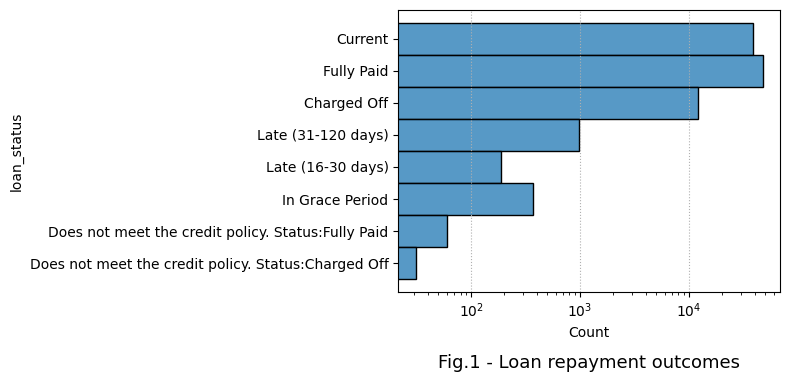

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
fig = sns.histplot(data, y='loan_status')
fig.set_title('Fig.1 - Loan repayment outcomes', y=-0.3, fontsize=13)
ax.set_xscale('log')
fig_id=1
plt.tight_layout()
ax.xaxis.grid(linestyle=':')
plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))
#fig.grid();

To simplify the task let us exclude customers who either do not meet the credit policy or who are in the grace period.

In [9]:
data['loan_status'].value_counts(True)

Fully Paid                                             0.474619
Current                                                0.388886
Charged Off                                            0.120345
Late (31-120 days)                                     0.009690
In Grace Period                                        0.003680
Late (16-30 days)                                      0.001870
Does not meet the credit policy. Status:Fully Paid     0.000600
Does not meet the credit policy. Status:Charged Off    0.000310
Name: loan_status, dtype: float64

In [10]:
data = data.query("loan_status in ['Current', 'Fully Paid', 'Fharged Off', 'Late (31-120 days)', 'Late (16-30 days)']")
data

,loan_amnt,term,int_rate,installment,...,hardship_flag,hardship_length,total_bal_il,settlement_percentage
0,32000.0,60 months,10.49,687.65,...,N,NaN,NaN,NaN
1,9600.0,36 months,12.99,323.42,...,N,NaN,NaN,NaN
2,4000.0,36 months,6.68,122.93,...,N,NaN,NaN,NaN
3,6025.0,36 months,10.91,197.00,...,N,NaN,2853.0,NaN
...,...,...,...,...,...,...,...,...,...
99996,25200.0,36 months,16.99,898.33,...,N,NaN,NaN,NaN
99997,10000.0,36 months,15.31,348.18,...,N,NaN,NaN,NaN
99998,20000.0,36 months,14.52,688.62,...,N,NaN,9802.0,NaN
99999,12000.0,36 months,6.39,367.19,...,N,NaN,NaN,NaN


In [11]:
cols_null_percent = data.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

settlement_percentage    99.952002
hardship_length          99.658297
total_bal_il             36.092477
emp_title                 7.263751
                           ...    
title                     0.866256
dti                       0.085711
revol_util                0.063998
pub_rec_bankruptcies      0.033142
Length: 10, dtype: float64

### settlement_percentage

In [15]:
get_descr('hardship_length')

The number of months the borrower will make smaller payments than normally obligated due to a hardship plan


In [16]:
data['hardship_length'].value_counts()

3.0    299
Name: hardship_length, dtype: int64

### Member_id

We will not use this feature for prediction.

In [31]:
#data.drop(['member_id'], axis=1, inplace=True)

### debt_settlement_flag_date

In [34]:
get_descr(feature='debt_settlement_flag_date')

The most recent date that the Debt_Settlement_Flag has been set  


In [35]:
data['debt_settlement_flag_date'].info()

KeyError: 'debt_settlement_flag_date'

In [ ]:
data['debt_settlement_flag_date'].value_counts()

KeyError: 'debt_settlement_flag_date'

In [ ]:
data['debt_settlement_flag_date'] = pd.to_datetime(data['debt_settlement_flag_date'], dayfirst=False).dt.date
data['debt_settlement_flag_date'].value_counts()

KeyError: 'debt_settlement_flag_date'

In [19]:
data['debt_settlement_flag_date'].isna().count()

87503

Let us encode the feature manually: 

<AxesSubplot: >

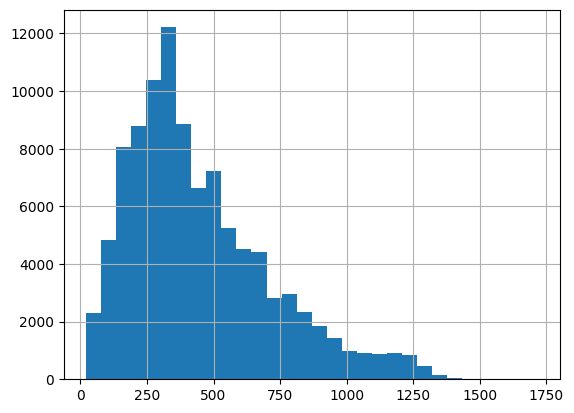

In [65]:
data['installment'].hist(bins=30)

In [72]:
data['term'].value_counts(True)

 36 months    0.710658
 60 months    0.289342
Name: term, dtype: float64

In [55]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,99996.00000,99996.000000,99996.000000,...,490.000000,1585.000000,1585.000000,1585.000000
mean,NaN,15081.25750,15076.493310,15060.101482,...,196.677469,5036.891691,47.700315,13.021451
std,NaN,9214.65121,9213.200242,9216.652945,...,195.609417,3690.770500,6.785504,8.124088
min,NaN,1000.00000,1000.000000,0.000000,...,0.020000,203.000000,15.000000,0.000000
25%,NaN,8000.00000,8000.000000,8000.000000,...,50.220000,2206.000000,45.000000,6.000000
50%,NaN,13000.00000,13000.000000,12900.000000,...,135.330000,4106.000000,45.000000,13.000000
75%,NaN,20000.00000,20000.000000,20000.000000,...,287.055000,6911.000000,50.000000,18.000000
max,NaN,40000.00000,40000.000000,40000.000000,...,1187.560000,23766.000000,90.000000,36.000000


In [54]:
data.columns.to_list()

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joi

In [ ]:
sns.histplot(data, y='loan_status')

<AxesSubplot: xlabel='loan_amnt'>

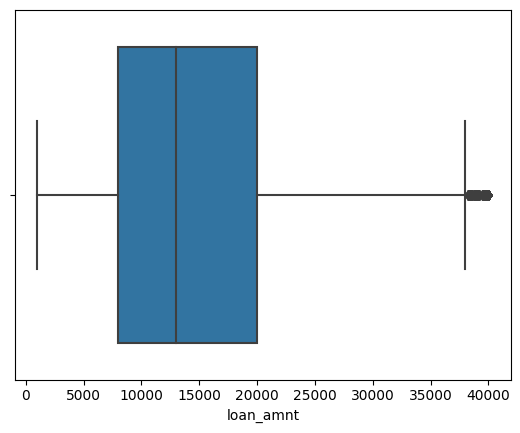

In [27]:
sns.boxplot(df, x='loan_amnt')

,id,member_id,loan_amnt,funded_amnt,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
392949,39651438,NaN,32000.0,32000.0,...,NaN,NaN,NaN,NaN
1273506,16411620,NaN,9600.0,9600.0,...,NaN,NaN,NaN,NaN
324024,45122316,NaN,4000.0,4000.0,...,NaN,NaN,NaN,NaN
2066630,125356772,NaN,6025.0,6025.0,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
363389,41368988,NaN,25200.0,25200.0,...,NaN,NaN,NaN,NaN
1908460,1513211,NaN,10000.0,10000.0,...,NaN,NaN,NaN,NaN
1487889,135125990,NaN,20000.0,20000.0,...,NaN,NaN,NaN,NaN
347653,43165428,NaN,12000.0,12000.0,...,NaN,NaN,NaN,NaN


In [ ]:
columns_list = df.columns.to_list()
columns_list

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '